In [1]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch import nn
import torch
import itertools
import numpy as np

from histaug.feature_extractors import CTransPath
from histaug.augmentations import Macenko
from histaug.data import Kather100k

/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = Kather100k("/data/NCT-CRC-HE-100K")
ds.classes

['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

In [3]:
loader = DataLoader(ds, batch_size=1024, shuffle=True, num_workers=8, pin_memory=True)

In [4]:
model = CTransPath()

/venv/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
imgs, labels = next(iter(loader))

In [6]:
def fliplr(imgs):
    return torch.flip(imgs, dims=[-1])


def flipud(imgs):
    return torch.flip(imgs, dims=[-2])


def rot90(imgs):
    return torch.rot90(imgs, k=1, dims=[-2, -1])


def randresizedcrop(imgs):
    return T.RandomResizedCrop((224, 224), scale=(0.6, 0.7), ratio=(0.8, 1.2))(imgs)


def randcrop(imgs):
    return T.RandomCrop((224, 224))(imgs)


def randaffine(imgs):
    return T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10)(imgs)


def colorjitter(imgs):
    return T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)(imgs)


AUG = colorjitter

In [15]:
_macenko = Macenko()  # .to("cuda")


def macenko(imgs: torch.Tensor):
    # return torch.stack([_macenko(img) for img in imgs])
    dev = imgs.device
    imgs = imgs.cpu()
    return torch.stack([_macenko(img) for img in imgs]).to(dev)


# def macenko(imgs: torch.Tensor):
#     res = []
#     for i, img in enumerate(imgs):
#         print(i)
#         res.append(_macenko(img))
#     return torch.stack(res)


AUG = macenko

In [16]:
model = model.cuda()

with torch.no_grad():
    imgs = imgs.cuda()
    feats = model(imgs)

    imgs_aug = AUG(imgs)
    feats_aug = model(imgs_aug)

2023-09-06 15:11:28.462 | WARNING  | histaug.augmentations:__call__:45 - Attempting to Macenko normalize fully transparent image. Returning original image.
2023-09-06 15:11:29.332 | WARNING  | histaug.augmentations:__call__:45 - Attempting to Macenko normalize fully transparent image. Returning original image.
2023-09-06 15:11:29.601 | WARNING  | histaug.augmentations:__call__:45 - Attempting to Macenko normalize fully transparent image. Returning original image.
2023-09-06 15:11:30.539 | WARNING  | histaug.augmentations:__call__:45 - Attempting to Macenko normalize fully transparent image. Returning original image.
2023-09-06 15:11:30.630 | WARNING  | histaug.augmentations:__call__:45 - Attempting to Macenko normalize fully transparent image. Returning original image.
2023-09-06 15:11:32.176 | WARNING  | histaug.augmentations:__call__:45 - Attempting to Macenko normalize fully transparent image. Returning original image.
2023-09-06 15:11:32.653 | WARNING  | histaug.augmentations:__cal

In [17]:
imgs.shape, imgs_aug.shape

(torch.Size([1024, 3, 224, 224]), torch.Size([1024, 3, 224, 224]))

In [18]:
imgs_aug.dtype, imgs.dtype

(torch.float32, torch.float32)

([], [])

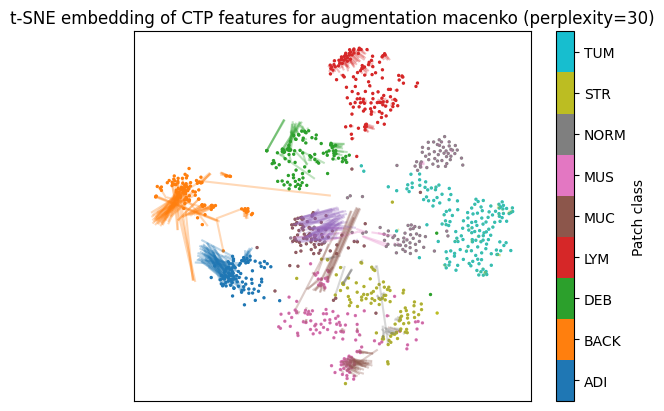

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D
import matplotlib

perplexity = 30
plt.figure()

# Generate embeddings using t-SNE
feats_cat = torch.cat([feats, feats_aug], dim=0).detach().cpu().numpy()
feats_embedded = TSNE(
    n_components=2, learning_rate="auto", init="random", random_state=0, perplexity=perplexity
).fit_transform(feats_cat)
feats_embedded, feats_aug_embedded = np.split(feats_embedded, 2, axis=0)

# Get labels for the reflected and non-reflected data
labels_cat = torch.cat([labels, labels], dim=0).numpy()
labels_embedded, labels_reflect_embedded = np.split(labels_cat, 2, axis=0)

# Use a colormap to map labels to colors
cmap = matplotlib.colormaps["tab10"]  # 'tab10' is a colormap suitable for categorical data up to 10 categories

# Draw lines and annotations
for f, f_reflect, label in zip(feats_embedded, feats_aug_embedded, labels):
    # plt.plot([f[0], f_reflect[0]], [f[1], f_reflect[1]], c="k", alpha=0.1)
    plt.plot([f[0], f_reflect[0]], [f[1], f_reflect[1]], c=cmap.colors[label.item()], alpha=0.3)

# Scatter plots
plt.scatter(feats_embedded[:, 0], feats_embedded[:, 1], c=labels_embedded, s=2, cmap=cmap)

# Add a colorbar to indicate which colors correspond to which labels
cbar = plt.colorbar(boundaries=np.arange(len(ds.classes) + 1) - 0.5)
cbar.set_ticks(range(len(ds.classes)))
cbar.set_ticklabels(ds.classes)
cbar.set_label("Patch class")

plt.title(f"t-SNE embedding of CTP features for augmentation {AUG.__name__} (perplexity={perplexity})")
plt.xticks([])
plt.yticks([])

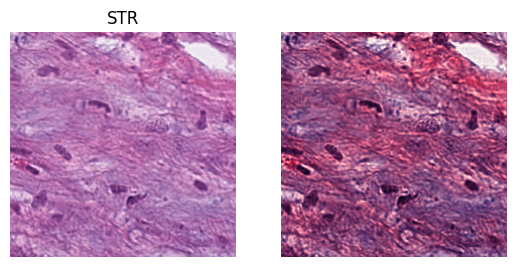

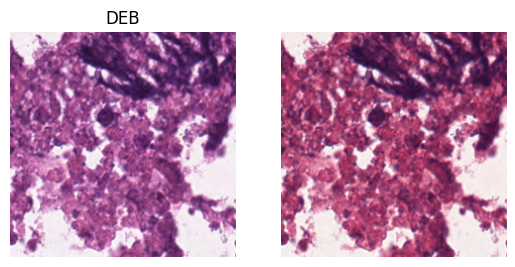

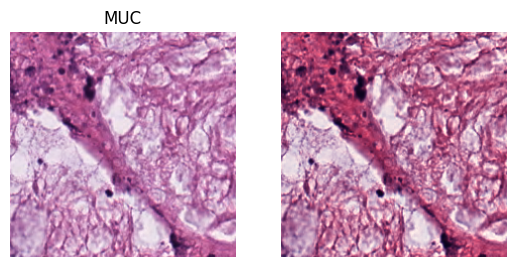

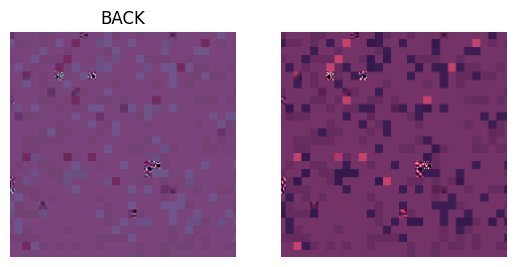

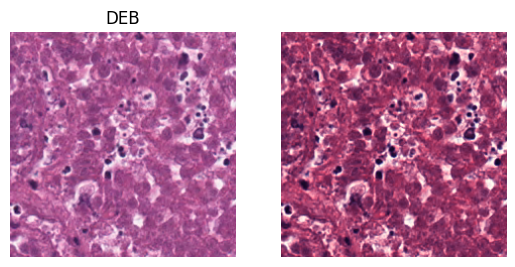

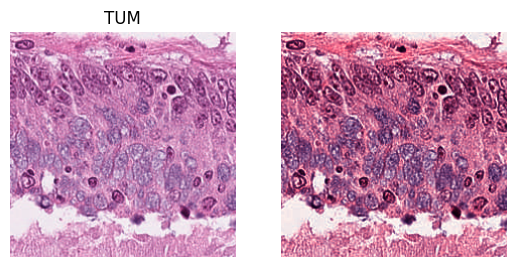

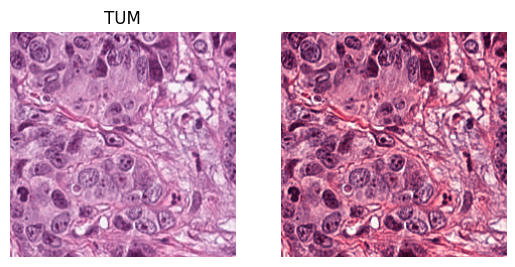

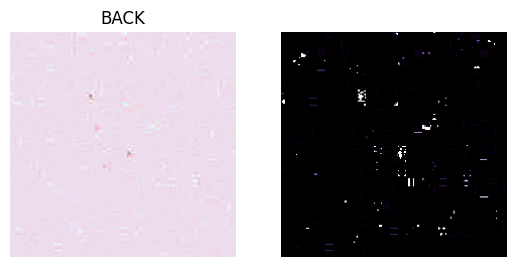

In [12]:
for i in range(8):
    plt.figure()
    plt.subplot(121)
    plt.title(ds.classes[labels[i].item()])
    plt.imshow(ds.inverse_transform(imgs[i]))
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ds.inverse_transform(imgs_aug[i]))
    plt.axis("off")